Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, February 12, 2022.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

DATA_URL = 'https://raw.githubusercontent.com/fonnesbeck/Bios8366/master/data/'

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

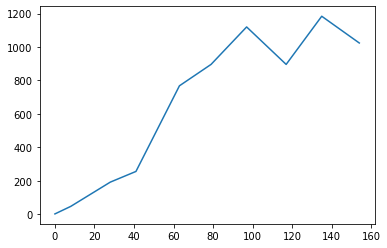

In [4]:
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

### 1.1

In [5]:
# define functions

from scipy import optimize

def log_growth_values(x):
    K, r = x
    
    return (K * No)/(No + (K - No) * np.exp(-r * t))

def sum_squared_errors(x, y):
    """
    x: array of predicted values
    y: array of true values
    """
    return ((x - y)**2).sum()

def opt_growth(x):
    
    predictions = log_growth_values(x)
    
    return sum_squared_errors(predictions, y)

def nelder_mead(f, x0):
    output = []
    
    def store(X):
        output.append([X[0], X[1], f(X)])
        
    optimize.fmin(f, x0, callback=store, ftol=1e-12)
    
    return np.array(output)

In [6]:
# set known parameter values
t = np.array(days)
y = np.array(beetles)
No = y[0]

In [7]:
nm_output = nelder_mead(opt_growth, np.array([10, 0]))
nm_output[-5:,:]

Optimization terminated successfully.
         Current function value: 83240.486583
         Iterations: 145
         Function evaluations: 317


array([[1.03351533e+03, 1.17958557e-01, 8.32404866e+04],
       [1.03351533e+03, 1.17958557e-01, 8.32404866e+04],
       [1.03351533e+03, 1.17958557e-01, 8.32404866e+04],
       [1.03351533e+03, 1.17958557e-01, 8.32404866e+04],
       [1.03351533e+03, 1.17958557e-01, 8.32404866e+04]])

In [8]:
print('Fitted values\nK: {0}\nr: {1}'.format(nm_output[-1][0], nm_output[-1][1]))

Fitted values
K: 1033.5153264185956
r: 0.11795855706698127


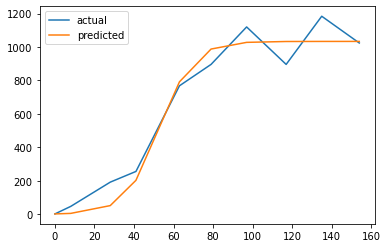

In [9]:
predicted_vals = log_growth_values(nm_output[-1][:2])
plt.plot(days, beetles, label='actual')
plt.plot(days, predicted_vals, label='predicted')
plt.legend()

## 1.2


In [55]:
# mean of observed values
mu = np.mean(np.log(beetles))

# number samples
n = len(days)

# standard deviation of observed values
sd = np.std(np.log(beetles))

mu, n, sd

(5.6614847743207415, 10, 1.927540451765516)

In [68]:
# negative log likelihood of normal distribution
def loglik_normal(X):
    
    x = log_growth_values(X)
    #print(mu, n, sd)

    return -(-(n/2) * np.log(sd**2) - n/2 * np.log(2 * np.pi) - ((np.log(x)-mu)**2).sum())/(2*sd**2)

In [86]:
from scipy.optimize import minimize

opt = minimize(loglik_normal, [1033, 0.1])
opt

      fun: 5.441686346973128
 hess_inv: array([[42067.61926094, -2681.08052559],
       [-2681.08052559,  2735.31757386]])
      jac: array([-4.76837158e-07, -8.22544098e-06])
  message: 'Optimization terminated successfully.'
     nfev: 141
      nit: 37
     njev: 47
   status: 0
  success: True
        x: array([287.62624389,   1.39470623])

In [87]:
opt.x

array([287.62624389,   1.39470623])

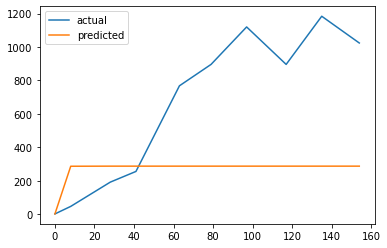

In [88]:
predicted_vals = log_growth_values(opt.x)
plt.plot(days, beetles, label='actual')
plt.plot(days, predicted_vals, label='predicted')
plt.legend()

In [89]:
# standard errors - square root of Hessian diagonal matrix
np.sqrt(np.diag(opt.hess_inv))

array([205.10392308,  52.30026361])

In [90]:
# correlation
np.linalg.inv(opt.hess_inv)[1, 0]

2.485240919915736e-05

## Question 2

1. Implement simulated annealing for minimizing the aic for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the aic for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



In [16]:
from sklearn.linear_model import LinearRegression

# read data
baseball = pd.read_table(DATA_URL + 'baseball.dat', sep='\s+')

In [17]:
# define predictors, outcome, parameters
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

In [18]:
# aic lambda function

aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

### 2.1 Simulated Annealing
#### A.

In [19]:
def SA_baseball(cooling_schedule, neighborhood_size = 1):
    
    # initialize
    aic_values = []
    
    # initial run
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    aic_best = aic(g, solution_vars, logsalary)
    aic_values.append(aic_best)

    for tau in cooling_schedule:

        # Random change
        flips = np.random.randint(0, ncols, size=neighborhood_size)
        solution_current[flips] = ~ solution_current[flips]
        solution_vars = predictors[predictors.columns[solution_current]]
        g = LinearRegression().fit(X=solution_vars, y=logsalary)
        aic_step = aic(g, solution_vars, logsalary)
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))

        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                solution_best = solution_current.copy()
        else:
            # Revert solution
            solution_current[flips] = ~ solution_current[flips]
            aic_values.append(aic_values[-1])
            
    return aic_values, solution_best

In [20]:
# cooling schedule in class

aic_vals = []
sols = []
aic_bests = []

# in class cooling schedule
tau_start = 10
cooling_schedule_inclass = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*240

# alternative cooling schedules
tau_start = 20
cooling_schedule_2 = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*240

tau_start = 20
cooling_schedule_3 = [tau_start]*10 + [tau_start/2]*180 + [tau_start/10]*500

tau_start = 40
cooling_schedule_4 = [tau_start]*100 + [tau_start/2]*120 + [tau_start/10]*120

tau_start = 10
cooling_schedule_5 = [tau_start]*10 + [tau_start/2]*300 + [tau_start/10]*300

cooling_schedules = [cooling_schedule_inclass, cooling_schedule_2, cooling_schedule_3,
                     cooling_schedule_4, cooling_schedule_5]

for sched in cooling_schedules:
    
    aicv, sol = SA_baseball(sched)
    aic_vals.append(aicv)
    sols.append(sol)
    aic_bests.append(min(aicv))

Cooling schedule: In class
Best aic: -420.9472114371547
Best solution: (array([ 1,  2,  5,  7,  9, 12, 13, 14, 15, 23, 24, 25]),)
Discovered at iteration 377

Cooling schedule: Schedule 2
Best aic: -417.4258866244491
Best solution: (array([ 2,  7,  8,  9, 12, 13, 18, 19, 20, 21, 24, 25]),)
Discovered at iteration 365

Cooling schedule: Schedule 3
Best aic: -418.3916743027919
Best solution: (array([ 2,  5,  7,  9, 11, 12, 13, 14, 15, 16, 19, 21, 24, 25]),)
Discovered at iteration 307

Cooling schedule: Schedule 4
Best aic: -411.6894864779291
Best solution: (array([ 0,  2,  3,  5,  6,  7,  9, 12, 13, 16, 17, 19, 20, 21, 24, 25]),)
Discovered at iteration 340

Cooling schedule: Schedule 5
Best aic: -415.7555349398046
Best solution: (array([ 2,  5,  7,  9, 11, 12, 13, 14, 15, 19, 22, 24, 25, 26]),)
Discovered at iteration 453



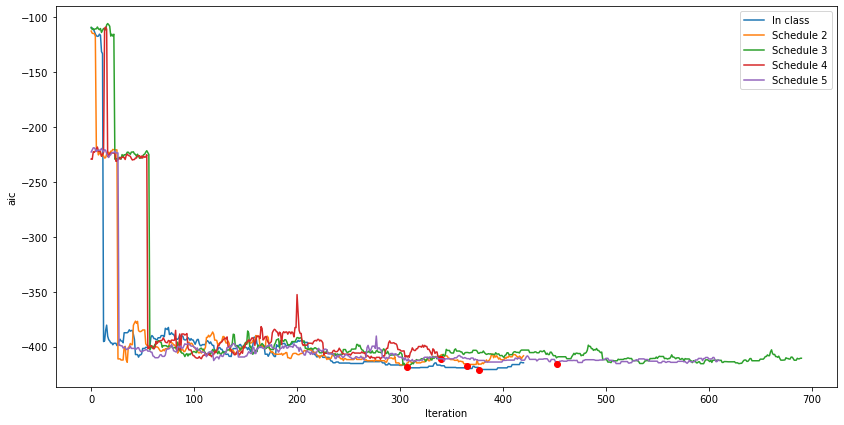

In [21]:
labels = ['In class', 'Schedule 2', 'Schedule 3', 'Schedule 4', 'Schedule 5']

fig, ax = plt.subplots(1, 1, figsize = (14, 7))


for i in range(len(labels)):
    lab = labels[i]
    aic_values = aic_vals[i]
    aic_best = aic_bests[i]
    solution_best = sols[i]

    ax.plot(aic_values, label = lab)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('aic')
    print('Cooling schedule: {0}'.format(lab)) 
    print('Best aic: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
                np.where(solution_best==True),
                np.where(aic_values==aic_best)[0][0]))
    print()
    ax.plot(np.where(aic_values==aic_best)[0][0], aic_best, 'ro')
    
ax.legend()

#### B.

In [22]:
aic_vals = []
sols = []
aic_bests = []

for neighborhood in [1, 2, 3]:
    
    aicv, sol = SA_baseball(cooling_schedule_inclass, neighborhood_size=neighborhood)
    aic_vals.append(aicv)
    sols.append(sol)
    aic_bests.append(min(aicv))
    

Cooling schedule: 1-neighborhood
Best aic: -417.87853037453976
Best solution: (array([ 1,  2,  5,  7,  9, 12, 13, 14, 15, 19, 23, 24, 26]),)
Discovered at iteration 407

Cooling schedule: 2-neighborhoods
Best aic: -417.9418582923682
Best solution: (array([ 0,  2,  7,  9, 12, 13, 14, 15, 16, 20, 24, 25]),)
Discovered at iteration 145

Cooling schedule: 3-neighborhoods
Best aic: -415.56074532798283
Best solution: (array([ 0,  2,  6,  7,  9, 11, 12, 13, 14, 15, 17, 19, 21, 24, 25]),)
Discovered at iteration 104



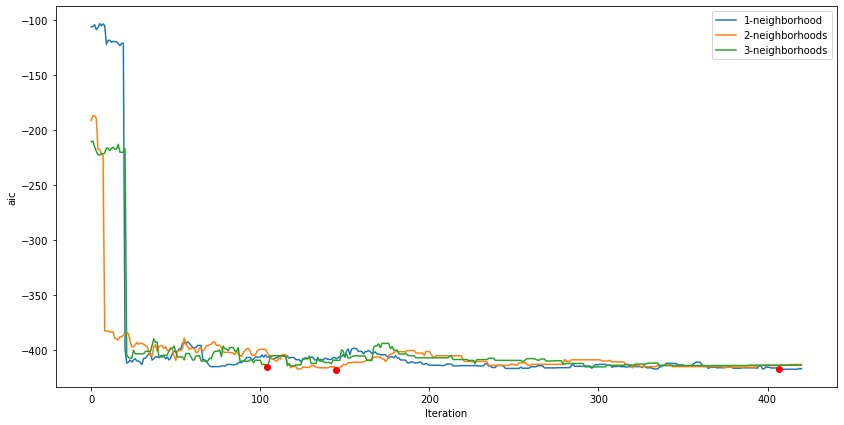

In [23]:
labels = ['1-neighborhood', '2-neighborhoods', '3-neighborhoods']

fig, ax = plt.subplots(1, 1, figsize = (14, 7))


for i in range(len(labels)):
    lab = labels[i]
    aic_values = aic_vals[i]
    aic_best = aic_bests[i]
    solution_best = sols[i]

    ax.plot(aic_values, label = lab)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('aic')
    print('Cooling schedule: {0}'.format(lab)) 
    print('Best aic: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
                np.where(solution_best==True),
                np.where(aic_values==aic_best)[0][0]))
    print()
    ax.plot(np.where(aic_values==aic_best)[0][0], aic_best, 'ro')
    
ax.legend()

### 2.2 Genetic Algorithms
#### A.

In [24]:
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

In [25]:
def genetic_baseball(pop_size, iterations, mutation_rate):
    
    # initialize
    aic_best = []
    best_solution = []
    aic_history = []
    
    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))

    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate aic
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest aic
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to aic rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly
        dads = np.random.choice(range(pop_size), size=int(pop_size/2))

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        
    return aic_best, best_solution

In [26]:
mutation_rates = np.arange(1, 6) * 0.01

aic_bests = []
best_sols = []

for rate in mutation_rates:
    
    a, b = genetic_baseball(pop_size=20,
                            iterations=100,
                            mutation_rate=rate)
    
    aic_bests.append(a)
    best_sols.append(b)

Mutation rate: 0.01
Best aic: -419.885762420057
Best solution: [1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1]
Discovered at iteration 72

Mutation rate: 0.02
Best aic: -415.96760810402805
Best solution: [0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0]
Discovered at iteration 64

Mutation rate: 0.03
Best aic: -420.4510619048349
Best solution: [1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0]
Discovered at iteration 74

Mutation rate: 0.04
Best aic: -417.4863358531028
Best solution: [0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0]
Discovered at iteration 83

Mutation rate: 0.05
Best aic: -419.4539499955935
Best solution: [0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0]
Discovered at iteration 56



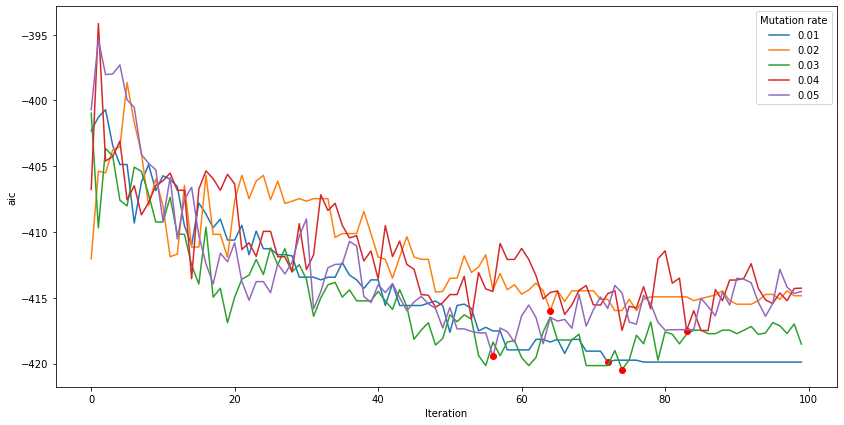

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))


for i in range(len(mutation_rates)):
    
    rate = mutation_rates[i]
    aic_best = aic_bests[i]
    best_sol = best_sols[i]

    ax.plot(aic_best, label = rate)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('aic')
    print('Mutation rate: {0}'.format(rate)) 
    print('Best aic: {0}\nBest solution: {1}\nDiscovered at iteration {2}'\
          .format(min(aic_best), 
                  best_sol[np.where(aic_best == min(aic_best))[0][0]],
                  np.where(aic_best == min(aic_best))[0][0]))
    print()
    ax.plot(np.where(aic_best == min(aic_best))[0][0], min(aic_best), 'ro')

ax.legend(title='Mutation rate')

#### B.

In [28]:
pop_sizes = np.arange(1, 6) * 6

aic_bests = []
best_sols = []

for size in pop_sizes:
    
    a, b = genetic_baseball(pop_size=size,
                            iterations=100,
                            mutation_rate=0.02)
    
    aic_bests.append(a)
    best_sols.append(b)

Generation size: 6
Best aic: -399.5276163652782
Best solution: [1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0]
Discovered at iteration 1

Generation size: 12
Best aic: -413.1467110047848
Best solution: [0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0]
Discovered at iteration 98

Generation size: 18
Best aic: -418.5068561149719
Best solution: [0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0]
Discovered at iteration 66

Generation size: 24
Best aic: -418.6118886471738
Best solution: [0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0]
Discovered at iteration 32

Generation size: 30
Best aic: -418.6030198380478
Best solution: [0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0]
Discovered at iteration 89



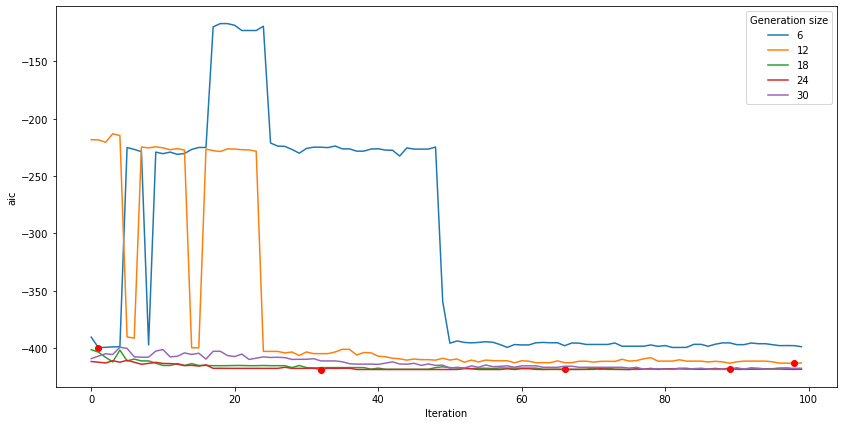

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))


for i in range(len(pop_sizes)):
    
    size = pop_sizes[i]
    aic_best = aic_bests[i]
    best_sol = best_sols[i]

    ax.plot(aic_best, label = size)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('aic')
    print('Generation size: {0}'.format(size)) 
    print('Best aic: {0}\nBest solution: {1}\nDiscovered at iteration {2}'\
          .format(min(aic_best), 
                  best_sol[np.where(aic_best == min(aic_best))[0][0]],
                  np.where(aic_best == min(aic_best))[0][0]))
    print()
    ax.plot(np.where(aic_best == min(aic_best))[0][0], min(aic_best), 'ro')

ax.legend(title='Generation size')

#### C.

In [30]:
def genetic_baseball_2(pop_size, iterations, mutation_rate):
    
    # initialize
    aic_best = []
    best_solution = []
    aic_history = []
    
    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))

    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate aic
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest aic
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to aic rank
        fitness = calculate_fitness(current_aic)

        # Choose both parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        
    return aic_best, best_solution

In [31]:
aic_bests = []
best_sols = []
funcs = [genetic_baseball, genetic_baseball_2]

for func in funcs:
    
    a, b = genetic_baseball(pop_size=20,
                            iterations=100,
                            mutation_rate=0.03)
    
    aic_bests.append(a)
    best_sols.append(b)

Genetic Algorithm version: In class
Best aic: -417.54315463052717
Best solution: [0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1]
Discovered at iteration 69

Genetic Algorithm version: Both fitness
Best aic: -420.4510619048349
Best solution: [1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0]
Discovered at iteration 88



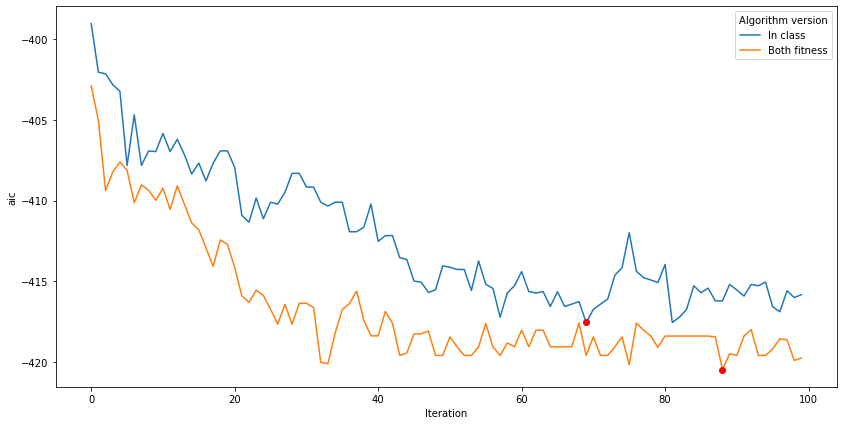

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))

func_labels = ['In class', 'Both fitness']

for i in range(len(funcs)):
    
    func = func_labels[i]
    aic_best = aic_bests[i]
    best_sol = best_sols[i]

    ax.plot(aic_best, label = func)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('aic')
    print('Genetic Algorithm version: {0}'.format(func)) 
    print('Best aic: {0}\nBest solution: {1}\nDiscovered at iteration {2}'\
          .format(min(aic_best), 
                  best_sol[np.where(aic_best == min(aic_best))[0][0]],
                  np.where(aic_best == min(aic_best))[0][0]))
    print()
    ax.plot(np.where(aic_best == min(aic_best))[0][0], min(aic_best), 'ro')

ax.legend(title='Algorithm version')

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). I will award 5 bonus points to the best solution!

In [2]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv(DATA_URL + 'brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

In [3]:
# function to measure Euclidean aic between sequence of cities
from scipy.spatial import distance

def city_dist(sel):
    dist = 0
    for i in range(len(sel) - 1):
        dist += distance.euclidean(cities.iloc[sel[i]], cities.iloc[sel[i+1]])
    return dist

# define helpful parameters
n_cities = len(cities)
home = 0
city_index = cities.index[1:]

In [4]:
def SA_tsp(cooling_schedule, neighborhood_size = 1):
    
    # initialize
    distance_values = []
    
    # initial run
    solution_current = solution_best = np.concatenate([[home], np.random.permutation(city_index), [home]])
    distance_best = city_dist(solution_current)
    distance_values.append(distance_best)

    for tau in cooling_schedule:

        # Random change
        flips = np.random.choice(city_index, size=neighborhood_size*2, replace=False)
        solution_current[flips] = solution_current[np.flip(flips)]
        distance_step = city_dist(solution_current)
        alpha = min(1, np.exp((distance_values[-1] - distance_step)/tau))

        if ((distance_step < distance_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            distance_values.append(distance_step)
            if distance_step < distance_best:
                # Replace previous best with this one
                distance_best = distance_step
                solution_best = solution_current.copy()
        else:
            # Revert solution
            solution_current[flips] = solution_current[np.flip(flips)]
            distance_values.append(distance_values[-1])
            
    return distance_values, solution_best

In [27]:
def cooling_schedule(tau_start, temp_fracs, iterations):
    
    taus = []
    for i in range(len(temp_fracs)):
        taus += [tau_start * temp_fracs[i]] * iterations [i]
        
    return taus

In [36]:
tau_start
distance_vals = []
sols = []
distance_bests = []

for neighborhood in [1, 2, 3]:
    
    for temp in [1, 2, 3]:
    
        distancev, sol = SA_tsp(cooling_schedule(tau_start * temp,
                                                 [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                                                 [30, 60, 120, 240, 360, 480]),
                                neighborhood_size=neighborhood)
        distance_vals.append(distancev)
        sols.append(sol)
        distance_bests.append(min(distancev))

Cooling schedule: n1-t1
Shortest distance: 150.59587596534598
Best solution: [ 0  1  2  4 12 10 15 20 25 24 23 22 17 13 16 18 21 19 14 11  9  8  7  5
  6  3  0]
Discovered at iteration 748

Cooling schedule: n1-t2
Shortest distance: 195.0798056292062
Best solution: [ 0 12 10  4 13 17 16 18 21 23 25 24  5  7  8  9 14 19 22 20 15  3  6 11
  2  1  0]
Discovered at iteration 682

Cooling schedule: n1-t3
Shortest distance: 198.26612645930987
Best solution: [ 0  1 18 19 21 22 23 25 24 17 16  6  5  2 13 14 11  9  8  7  3  4 20 15
 12 10  0]
Discovered at iteration 767

Cooling schedule: n2-t1
Shortest distance: 224.50039098931637
Best solution: [ 0 12 10  5  7  3  6  4  1  2 13 16 19 21 20 23 22 25 24  8  9 11 14 18
 17 15  0]
Discovered at iteration 425

Cooling schedule: n2-t2
Shortest distance: 228.59914603450713
Best solution: [ 0 14 11 16 17 24 23 22 25 10 12  1  2  3  5  6  8  7  9 13 20 21 18 19
 15  4  0]
Discovered at iteration 785

Cooling schedule: n2-t3
Shortest distance: 210.4604

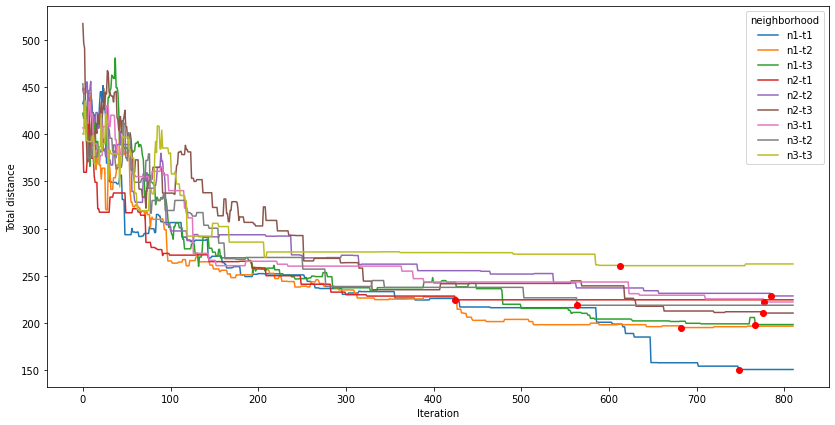

In [31]:
labels = ['n1-t1','n1-t2','n1-t3', 'n2-t1','n2-t2','n2-t3', 'n3-t1','n3-t2','n3-t3']

fig, ax = plt.subplots(1, 1, figsize = (14, 7))


for i in range(len(labels)):
    lab = labels[i]
    distance_values = distance_vals[i]
    distance_best = distance_bests[i]
    solution_best = sols[i]

    ax.plot(distance_values, label = lab)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total distance')
    print('Cooling schedule: {0}'.format(lab)) 
    print('Shortest distance: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(distance_best, 
                solution_best,
                np.where(np.isclose(distance_values,distance_best) == True)[0][0]))
    print()
    ax.plot(np.where(np.isclose(distance_values,distance_best) == True)[0][0], distance_best, 'ro')
    
ax.legend(title='neighborhood')

Cooling schedule: n1-t1

Shortest distance: 150.59587596534598

Best solution: [ 0  1  2  4 12 10 15 20 25 24 23 22 17 13 16 18 21 19 14 11  9  8  7  5
  6  3  0]
  
Discovered at iteration 748

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

**Answer:** Here, I consider total daily cases and deaths as both the confirmed and probable counts, not the suspected counts.

In [80]:
## Guinea

# list of file names
guin_files = !ls ../data/ebola/guinea_data/


In [81]:
# concatenate files
guin = []
for gfile in guin_files:
    guin.append(pd.read_csv('../data/ebola/guinea_data/' + gfile))
    
guin_df = pd.concat(guin)

In [82]:
# combine cases and death labels
guin_df['Type'] = 'None'
guin_df.loc[guin_df.Description.isin(['Total cases of probables',
       'Total cases of confirmed']), 'Type'] = 'Cases'
guin_df.loc[guin_df.Description.isin(['Total deaths of probables',
       'Total deaths of confirmed']), 'Type'] = 'Deaths'

# format Date column
guin_df['Date'] = pd.to_datetime(guin_df['Date'])

# sum totals
guin_summed = guin_df[guin_df.Type != 'None'].groupby(['Date','Type'])\
                     .agg({'Totals':'sum'})\
                     .reset_index()\
                     .pivot_table(index='Date', columns='Type', values='Totals')\
                     .sort_index()
# fill missing values
guin_summed[guin_summed == 0] = None
guin_filled = guin_summed.fillna(method='ffill')

# convert cumulative counts to daily counts
guin_daily = guin_filled.diff().reset_index()
guin_daily.loc[0, ['Cases', 'Deaths']] = guin_filled.loc[guin_filled.index[0], ['Cases', 'Deaths']] # add first row back in
guin_daily['Country'] = 'Guinea'
guin_daily

Type,Date,Cases,Deaths,Country
0,2014-08-04,484.0,361.0,Guinea
1,2014-08-26,141006.0,140931.0,Guinea
2,2014-08-27,1009.0,1002.0,Guinea
3,2014-08-30,34.0,30.0,Guinea
4,2014-08-31,8030.0,8013.0,Guinea
5,2014-09-02,28.0,12.0,Guinea
6,2014-09-04,1030.0,1019.0,Guinea
7,2014-09-07,57.0,34.0,Guinea
8,2014-09-08,0.0,0.0,Guinea
9,2014-09-09,5.0,8.0,Guinea


In [83]:
## Liberia

# list of file names
lib_files = !ls ../data/ebola/liberia_data/

In [84]:
# concatenate files

lib = []
for lfile in lib_files:
    lib.append(pd.read_csv('../data/ebola/liberia_data/' + lfile))
    
lib_df = pd.concat(lib)

In [85]:
# combine cases and death labels
lib_df['Type'] = 'None'
lib_df.loc[lib_df.Variable.isin(['Total probable cases',
       'Total confirmed cases']), 'Type'] = 'Cases'
lib_df.loc[lib_df.Variable.isin(['Total death/s in confirmed cases',
       'Total death/s in probable cases']), 'Type'] = 'Deaths'

# format Date column
lib_df['Date'] = pd.to_datetime(lib_df['Date'])

# sum totals
lib_summed = lib_df[lib_df.Type != 'None'].groupby(['Date','Type'])\
                     .agg({'National':'sum'})\
                     .reset_index()\
                     .pivot_table(index='Date', columns='Type', values='National')\
                     .sort_index()
# fill missing values
lib_summed[lib_summed == 0] = None
lib_filled = lib_summed.fillna(method='ffill')

# convert cumulative counts to daily counts
lib_daily = lib_filled.diff().reset_index()
lib_daily.loc[0, ['Cases', 'Deaths']] = lib_filled.loc[lib_filled.index[0], ['Cases', 'Deaths']] # add first row back in
lib_daily['Country'] = 'Liberia'
lib_daily

Type,Date,Cases,Deaths,Country
0,2014-06-16,18.0,14.0,Liberia
1,2014-06-17,0.0,0.0,Liberia
2,2014-06-22,18.0,10.0,Liberia
3,2014-06-24,5.0,2.0,Liberia
4,2014-06-25,3.0,2.0,Liberia
...,...,...,...,...
95,2014-12-05,0.0,0.0,Liberia
96,2014-12-06,0.0,0.0,Liberia
97,2014-12-07,0.0,0.0,Liberia
98,2014-12-08,0.0,0.0,Liberia


In [86]:
## Sierra Leone

# list of file names
sl_files = !ls ../data/ebola/sl_data/

In [87]:
# concatenate files

sl = []
for slfile in sl_files:
    sl.append(pd.read_csv('../data/ebola/sl_data/' + slfile))
    
sl_df = pd.concat(sl)

In [89]:
# combine cases and death labels
sl_df['Type'] = 'None'
sl_df.loc[sl_df.variable.isin(['cum_probable',
       'cum_confirmed']), 'Type'] = 'Cases'
sl_df.loc[sl_df.variable.isin(['death_probable',
                              'death_confirmed']), 'Type'] = 'Deaths'

# format Date column
sl_df['Date'] = pd.to_datetime(sl_df['date'])

# clean National column
sl_df['National'] = sl_df['National'].str.replace(',','')

# sum totals
sl_summed = sl_df[sl_df.Type != 'None'].fillna(0).astype({'National':int})\
                     .groupby(['Date','Type'])\
                     .agg({'National':'sum'})\
                     .reset_index()\
                     .pivot_table(index='Date', columns='Type', values='National')\
                     .sort_index()

# fill missing values
sl_summed[sl_summed == 0] = None
sl_filled = sl_summed.fillna(method='ffill')

# convert cumulative counts to daily counts
sl_daily = sl_filled.diff().reset_index()
sl_daily.loc[0, ['Cases', 'Deaths']] = sl_filled.loc[sl_filled.index[0], ['Cases', 'Deaths']] # add first row back in
sl_daily['Country'] = 'Sierra Leone'
sl_daily

Type,Date,Cases,Deaths,Country
0,2014-08-12,754.0,298.0,Sierra Leone
1,2014-08-13,17.0,9.0,Sierra Leone
2,2014-08-14,15.0,7.0,Sierra Leone
3,2014-08-15,8.0,7.0,Sierra Leone
4,2014-08-16,15.0,10.0,Sierra Leone
...,...,...,...,...
98,2014-12-01,211.0,68.0,Sierra Leone
99,2014-12-04,260.0,99.0,Sierra Leone
100,2014-12-05,54.0,21.0,Sierra Leone
101,2014-12-06,0.0,0.0,Sierra Leone


In [79]:
# combine all daily counts df's into one

final_df = pd.concat([guin_daily, lib_daily, sl_daily])
final_df.columns.name = ''
final_df

,Date,Cases,Deaths,Country
0,2014-08-04,484.0,361.0,Guinea
1,2014-08-26,141006.0,140931.0,Guinea
2,2014-08-27,1009.0,1002.0,Guinea
3,2014-08-30,34.0,30.0,Guinea
4,2014-08-31,8030.0,8013.0,Guinea
...,...,...,...,...
98,2014-12-01,211.0,68.0,Sierra Leone
99,2014-12-04,260.0,99.0,Sierra Leone
100,2014-12-05,54.0,21.0,Sierra Leone
101,2014-12-06,0.0,0.0,Sierra Leone
